<h1>This notebook is an exploration of the structure of the forcing files used for MOHID<h1>
    <ol>
        <li>
            <a href="#winds">Winds</a>
        </li>
        <li>
            <a href="#currents">Currents</a>
        </li>
        <li>
            <a href="#createwind">Create Wind Input file Structure</a>
        </li>
        <li>
            <a href="#createcurrents">Create Current Input file Structure</a>
        </li>
        <li>
            <a href="#compare">Compare Stuctures</a>
        </li>
    </ol>

In [1]:
import numpy as np
from tables import * 
import xarray as xr
import datetime as datetime
from salishsea_tools import viz_tools
from salishsea_tools import utilities
import matplotlib.pyplot as plt
import time
from scipy.interpolate import griddata
import datetime 

<div id='winds'><a name='Winds'></a><h2>Winds</h2></div>

In [72]:
h5wind = open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/st_georgia_wind.hdf5')
for group in h5wind.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/wind velocity X (Group) ''
/Results/wind velocity Y (Group) ''


<div id='currents'><a name='Currents'></a><h2>Currents</h2></div>

In [103]:
h5current = open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/St_georgia.hdf5')
for group in h5current.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/velocity U (Group) ''
/Results/velocity V (Group) ''
/Results/water level (Group) ''


In [36]:
for time in getattr(h5current.root.Time, 'Time_00168'):
    print(time)

2015.0
4.0
14.0
22.0
30.0
0.0


In [73]:
a = np.asarray(getattr(getattr(h5current.root.Results, 'velocity U'), 'velocity U_00001'))

NameError: name 'h5current' is not defined

In [74]:
np.asarray(getattr(getattr(h5wind.root.Results, 'wind velocity X'), 'wind velocity X_00001'))

array([[-0.74302644, -0.76153574, -0.77833818, ...,  0.48724736,
         0.48393026,  0.47845542],
       [-0.71999967, -0.7400126 , -0.76024208, ...,  0.52903059,
         0.54043164,  0.54524015],
       [-0.69680189, -0.71708377, -0.73748427, ...,  0.57687305,
         0.58942564,  0.61182992],
       ...,
       [-0.55848224, -0.53850472, -0.51852719, ...,  1.41692917,
         1.4566358 ,  1.49616777],
       [-0.50492741, -0.48498929, -0.46501176, ...,  1.36433298,
         1.40420943,  1.44391605],
       [-0.41219392, -0.41882186, -0.41145693, ...,  1.32995414,
         1.35195771,  1.39183173]])

In [4]:
GEM = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/hrdps/28nov17-05dec17/GEM.nc')

In [5]:
GEM

<xarray.Dataset>
Dimensions:       (time_counter: 192, x: 256, y: 266)
Coordinates:
  * time_counter  (time_counter) datetime64[ns] 2017-11-28 ... 2017-12-05T23:00:00
  * x             (x) float64 0.0 2.5e+03 5e+03 ... 6.325e+05 6.35e+05 6.375e+05
  * y             (y) float64 0.0 2.5e+03 5e+03 ... 6.575e+05 6.6e+05 6.625e+05
Data variables:
    atmpres       (time_counter, y, x) float32 ...
    nav_lat       (y, x) float64 ...
    nav_lon       (y, x) float64 ...
    percentcloud  (time_counter, y, x) float32 ...
    precip        (time_counter, y, x) float32 ...
    qair          (time_counter, y, x) float32 ...
    solar         (time_counter, y, x) float32 ...
    tair          (time_counter, y, x) float32 ...
    therm_rad     (time_counter, y, x) float32 ...
    u_wind        (time_counter, y, x) float32 ...
    v_wind        (time_counter, y, x) float32 ...
Attributes:
    Conventions:               CF-1.0
    History:                   Fri Feb  1 12:47:06 2019: ncrcat /results/

<div id='createwind'><a name='Currents'></a><h2>Create wind input file structure</h2></div>

In [40]:
# make hdf5 fle for currents
h5file = open_file("temp/winds.hdf5", mode="w", title="Winds Test file")

times = h5file.create_group("/", 'Time', 'Time')
results = h5file.create_group("/", 'Results', 'Results')
wind_u = h5file.create_group(results, 'wind velocity X', 'wind velocity X')
wind_v = h5file.create_group(results, 'wind velocity Y', 'wind velocity Y')

/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'wind velocity X'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'wind velocity Y'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)


In [3]:
GEM = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/hrdps/07apr15-16apr15/GEM.nc').isel(time_counter = slice(23,240))

In [4]:
# lat lon data
GEM_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSaAtmosphereGridV1')
NEMO_grid = xr.open_dataset('https://salishsea.eos.ubc.ca/erddap/griddap/ubcSSnBathymetryV17-02')

# GEM data coordinates
points = np.array([GEM_grid.latitude.values.ravel(), GEM_grid.longitude.values.ravel()-360]).T
# NEMO lat lon grids tuple
xi = (NEMO_grid.latitude.values, NEMO_grid.longitude.values)


# GEM Data

GEM_u = GEM.u_wind.values
GEM_v = GEM.v_wind.values

bar = utilities.statusbar('Loading ...')
u_wind = np.expand_dims(griddata(points, GEM_u[0].ravel(), xi, method='cubic'),0)
v_wind = np.expand_dims(griddata(points, GEM_v[0].ravel(), xi, method='cubic'),0)
for grid in bar(range(1, GEM_u.shape[0])):
    interp_u = griddata(points, GEM_u[grid].ravel(), xi, method='cubic')
    u_wind = np.vstack((u_wind, np.expand_dims(interp_u,0)))
    interp_v = griddata(points, GEM_v[grid].ravel(), xi, method='cubic')
    v_wind = np.vstack((v_wind, np.expand_dims(interp_v,0)))

Loading ... 100% (216 of 216) |#################################|Time:  0:08:03


In [5]:
u_wind1 = u_wind[...,:,1:897:,1:397].astype('float64')
v_wind1 = v_wind[...,:,1:897:,1:397].astype('float64')

In [6]:
u_wind2 = np.transpose(u_wind1, [0,2,1])
v_wind2 = np.transpose(v_wind1, [0,2,1])

In [42]:
datelist = GEM.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
datearrays = []
filters =  Filters(complevel=4)
for date in datelist:
    datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
bar = utilities.statusbar('Writing Dates ...')
for i in bar(range(len(datearrays))):
    time_attr = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    h5file.create_carray(times, f'{time_attr}',obj = datearrays[i],shape=(6,), chunkshape = (6,), filters = Filters)
bar = utilities.statusbar('Writing U winds ...')
for i in bar(range(u_wind2.shape[0])):
    velocity_attr = 'wind velocity X_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    h5file.create_carray(wind_u, f'{velocity_attr}',obj = u_wind2[i],shape=(396, 896), chunkshape = (396, 896), filters = Filters)
bar = utilities.statusbar('Writing Y winds ...')
for i in bar(range(v_wind2.shape[0])):
    velocity_attr = 'wind velocity Y_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    h5file.create_carray(wind_v, f'{velocity_attr}',obj = v_wind2[i],shape=(396, 896), chunkshape = (396, 896), filters = Filters)
h5file.close()

Writing Dates ... N/A% (0 of 217) |                             |ETA:  --:--:--

TypeError: filter parameter has to be None or a Filter instance and the passed type is: '<class 'type'>'

<div id='createcurrents'><a name='Currents'></a><h2>Create currents input file structure</h2></div>

In [2]:
strt = time.time()

In [3]:
# make hdf5 fle for currents
h5file = open_file("temp/currents.hdf5", mode="w", title="Currents Test file")

# make tree structure
times = h5file.create_group("/", 'Time', '')
results = h5file.create_group("/", 'Results', '')
velocity_u = h5file.create_group(results, 'velocity U', '')
velocity_v = h5file.create_group(results, 'velocity V', '')
water_level = h5file.create_group(results, 'water level', '')

/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'velocity U'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'velocity V'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still work, though
  NaturalNameWarning)
/home/abhudia/anaconda3/lib/python3.7/site-packages/tables/path.py:112: NaturalNameWarning: object name is not a valid Python identifier: 'water level'; it does not match the pattern ``^[a-zA-Z_][a-zA-Z0-9_]*$``; you will not be able to use natural naming to access this object; using ``getattr()`` will still wo

In [ ]:
# write in chunks of size 12
sliceend = 35
slicebegin = 23
num_disp = 0
count = 0
while sliceend <= 191:
    U = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/U.nc').isel(time_counter = slice(slicebegin,sliceend))
    V = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/V.nc').isel(time_counter = slice(slicebegin,sliceend))
    T = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/T.nc').isel(time_counter = slice(slicebegin,sliceend))
    datelist = U.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
    # unstagger
    unstaggered_U  = viz_tools.unstagger_xarray(U.vozocrtx, 'x').values[...,:,1:897:,1:397]
    unstaggered_V  = viz_tools.unstagger_xarray(V.vomecrty, 'y').values[...,:,1:897:,1:397]
    unstaggered_T = T.sossheig.values[...,:,1:897:,1:397]
    # rotate
    current_u, current_v = viz_tools.rotate_vel(unstaggered_U, unstaggered_V)
    # clear memory
    unstaggered_U, unstaggered_V = 0,0
    # transpose grid
    current_u = np.transpose(current_u, [0,1,3,2])
    current_v = np.transpose(current_v, [0,1,3,2])
    unstaggered_T = np.transpose(unstaggered_T, [0,2,1])
    # flip by depth dimension
    current_u = np.flip(np.nan_to_num(current_u).astype('float64'), axis = 1)
    current_v = np.flip(np.nan_to_num(current_v).astype('float64'), axis = 1)
    
    unstaggered_T = np.nan_to_num(unstaggered_T).astype('float64')
    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
    # write u wind values to hdf5
    for i in range(current_u.shape[0]):
        velocity_attr = 'velocity U_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(velocity_u, f'{velocity_attr}',obj = current_u[i],shape=(40, 396, 896), chunkshape = (40, 396, 896))

    # write v wind values to hdf5
    for i in range(current_v.shape[0]):
        velocity_attr = 'velocity V_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(velocity_v, f'{velocity_attr}',obj = current_v[i],shape=(40, 396, 896), chunkshape = (40, 396, 896))

    # write  water level values to hdf5
    for i in range(unstaggered_T.shape[0]):
        level_attr = 'water level_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(water_level, f'{level_attr}',obj = unstaggered_T[i],shape=(396, 896), chunkshape = (396, 896))
    
    # write time values to hdf5
    for i in range(len(datearrays)):
        time_attr = 'Time_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        h5file.create_carray(times, f'{time_attr}',obj = datearrays[i],shape=(6,), chunkshape = (6,))
    num_disp = num_disp + current_u.shape[0]
    slicebegin = sliceend
    sliceend = sliceend + 12
    count = count + 1
    print(count)

In [5]:
h5file.close()

In [6]:
print(time.time() - strt)

525.8948543071747


<div id='compare'><a name='Compare'></a><h2>Compare</h2></div>

compare the structure and check order of entries

In [7]:
shihan = open_file('/ocean/abhudia/MEOPAR/analysis-ashutosh/temp/St_georgia.hdf5')
for group in shihan.walk_groups():
    print(group)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/velocity U (Group) ''
/Results/velocity V (Group) ''
/Results/water level (Group) ''


In [8]:
ashu = open_file('temp/currents.hdf5')
for group in ashu.walk_groups():
    print(group)

/ (RootGroup) 'Currents Test file'
/Results (Group) ''
/Time (Group) ''
/Results/velocity U (Group) ''
/Results/velocity V (Group) ''
/Results/water level (Group) ''


In [9]:
shihan.root.Results

/Results (Group) ''
  children := ['velocity U' (Group), 'velocity V' (Group), 'water level' (Group)]

In [10]:
ashu.root.Results

/Results (Group) ''
  children := ['velocity U' (Group), 'velocity V' (Group), 'water level' (Group)]

In [11]:
s = np.asarray(getattr(getattr(shihan.root.Results, 'velocity U'), 'velocity U_00001'))

In [12]:
a = np.asarray(getattr(getattr(ashu.root.Results, 'velocity U'), 'velocity U_00001'))

In [13]:
np.asarray(getattr(shihan.root.Time, 'Time_00001'))

array([2015.,    4.,    7.,   23.,   30.,    0.])

In [14]:
np.asarray(getattr(ashu.root.Time, 'Time_00001'))

array([2015.,    4.,    7.,   23.,   30.,    0.])

In [25]:
getattr(shihan.root.Time, 'Time_00001').attrs

/Time/Time_00001._v_attrs (AttributeSet), 3 attributes:
   [Maximum := array([2016.]),
    Minimum := array([-0.]),
    Units := b'YYYY/MM/DD HH:MM:SS']

In [24]:
getattr(ashu.root.Time, 'Time_00001').attrs

/Time/Time_00001._v_attrs (AttributeSet), 3 attributes:
   [CLASS := 'CARRAY',
    TITLE := '',
    VERSION := '1.1']

In [27]:
np.max(s[-1])

4.615175247192383

In [26]:
np.max(a[-1])

4.112582683563232

### Let's have a look at the surface currents

In [18]:
index = -1

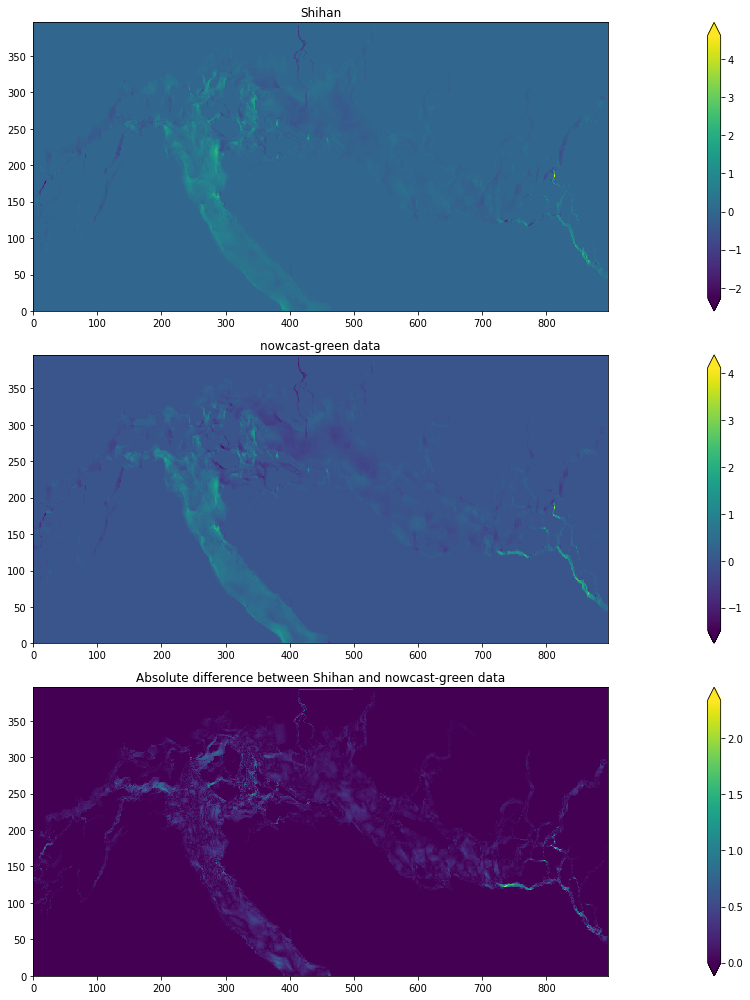

In [30]:
fig = plt.figure(figsize = (28,14))
ax = plt.subplot(3,1,1)
plt.pcolormesh(s[index])
plt.colorbar(extend = 'both')
plt.title('Shihan')
viz_tools.set_aspect(ax)
ax = plt.subplot(3,1,2)
plt.pcolormesh(a[index])
plt.colorbar(extend = 'both')
plt.title('nowcast-green data')
viz_tools.set_aspect(ax)
ax = plt.subplot(3,1,3)
plt.pcolormesh(np.abs(s[index]-a[index]))
plt.colorbar(extend = 'both')
plt.title('Absolute difference between Shihan and nowcast-green data')
viz_tools.set_aspect(ax)
plt.tight_layout()

# My grids have the same or fewer empty rows and columns than Shihan's at each depth value

In [20]:
# number of empty rows in shihan's grid
number = []
for index in range(40):
    rows = 0
    for i in range(396):
        if np.sum(s[index][i]) == 0:
            rows = rows+ 1
    number.append(rows)
print(number)

[396, 223, 218, 206, 193, 180, 141, 99, 72, 30, 20, 17, 16, 14, 14, 13, 13, 12, 12, 12, 12, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 8, 5, 3, 3, 3, 3, 3, 3, 3]


In [21]:
# number of empty rows in ashu's grid
number = []
for index in range(40):
    rows = 0
    for i in range(396):
        if np.sum(a[index][i]) == 0:
            rows = rows+ 1
    number.append(rows)
print(number)

[396, 221, 215, 204, 191, 176, 134, 92, 66, 26, 18, 16, 15, 13, 13, 12, 12, 11, 11, 11, 11, 10, 10, 10, 10, 10, 10, 10, 10, 10, 9, 6, 3, 2, 2, 2, 2, 2, 2, 2]


In [22]:
# number of empty cols in shihan's grid
number = []
for index in range(40):
    rows = 0
    for i in range(396):
        if np.sum(s[index].T[i]) == 0:
            rows = rows+ 1
    number.append(rows)
print(number)

[396, 396, 396, 396, 392, 386, 373, 315, 243, 173, 123, 71, 35, 12, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [23]:
# number of empty cols in ashu's grid
number = []
for index in range(40):
    rows = 0
    for i in range(396):
        if np.sum(a[index].T[i]) == 0:
            rows = rows+ 1
    number.append(rows)
print(number)

[396, 396, 396, 396, 391, 380, 365, 302, 234, 165, 111, 64, 31, 8, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


# Trying with h5py compression

# winds

In [33]:
import h5py

In [34]:
f = h5py.File('foo.hdf5', 'w')

In [36]:
results = f.create_group('Results')

In [37]:
times = f.create_group('Time')
windu = f.create_group('/Results/wind velocity X')
windx = f.create_group('/Results/wind velocity Y')

In [39]:
datelist = GEM.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
datearrays = []
for date in datelist:
    datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
bar = utilities.statusbar('Writing Dates ...')
for i in bar(range(len(datearrays))):
    time_attr = 'Time_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    times.create_dataset(time_attr, shape = (6,), data = datearrays[i],chunks=(6,), compression = 'gzip', compression_opts = 9)
    #h5file.create_carray(times, f'{time_attr}',obj = datearrays[i],shape=(6,), chunkshape = (6,))
bar = utilities.statusbar('Writing X winds ...')
for i in bar(range(u_wind2.shape[0])):
    velocity_attr = 'wind velocity X_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    windu.create_dataset(velocity_attr, shape = (396, 896), data = u_wind2[i],chunks=(396, 896), compression = 'gzip', compression_opts = 9)
    #h5file.create_carray(wind_u, f'{velocity_attr}',obj = u_wind2[i],shape=(396, 896), chunkshape = (396, 896))
bar = utilities.statusbar('Writing Y winds ...')
for i in bar(range(v_wind2.shape[0])):
    velocity_attr = 'wind velocity Y_' + ((5 - len(str(i + 1))) * '0') + str(i + 1)
    windx.create_dataset(velocity_attr, shape = (396, 896), data = v_wind2[i],chunks=(396, 896), compression = 'gzip', compression_opts = 9)
    #h5file.create_carray(wind_v, f'{velocity_attr}',obj = v_wind2[i],shape=(396, 896), chunkshape = (396, 896))
f.close()

Writing Dates ... 100% (217 of 217) |###########################|Time:  0:00:00
Writing X winds ... 100% (217 of 217) |#########################|Time:  0:00:19
Writing Y winds ... 100% (217 of 217) |#########################|Time:  0:00:21


# currents

In [96]:
compression_level = 1
f = h5py.File('foocurrents.hdf5', 'w')
results = f.create_group('Results')
times = f.create_group('Time')
velocity_u = f.create_group('/Results/velocity U')
velocity_v = f.create_group('/Results/velocity V')
water_level = f.create_group('/Results/water level')

# write in chunks of size 12
sliceend = 35
slicebegin = 23
num_disp = 0
count = 0
while sliceend <= 35: #191
    U = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/U.nc').isel(time_counter = slice(slicebegin,sliceend))
    V = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/V.nc').isel(time_counter = slice(slicebegin,sliceend))
    T = xr.open_dataset('/results2/MIDOSS/forcing/SalishSeaCast/nowcast-green/07apr15-14apr15/T.nc').isel(time_counter = slice(slicebegin,sliceend))
    datelist = U.time_counter.values.astype('datetime64[s]').astype(datetime.datetime)
    # unstagger
    unstaggered_U  = viz_tools.unstagger_xarray(U.vozocrtx, 'x').values[...,:,1:897:,1:397]
    unstaggered_V  = viz_tools.unstagger_xarray(V.vomecrty, 'y').values[...,:,1:897:,1:397]
    unstaggered_T = T.sossheig.values[...,:,1:897:,1:397]
    # rotate
    current_u, current_v = viz_tools.rotate_vel(unstaggered_U, unstaggered_V)
    # clear memory
    unstaggered_U, unstaggered_V = 0,0
    # transpose grid
    current_u = np.transpose(current_u, [0,1,3,2])
    current_v = np.transpose(current_v, [0,1,3,2])
    unstaggered_T = np.transpose(unstaggered_T, [0,2,1])
    # flip by depth dimension
    current_u = np.flip(np.nan_to_num(current_u).astype('float64'), axis = 1)
    current_v = np.flip(np.nan_to_num(current_v).astype('float64'), axis = 1)
    unstaggered_T = np.nan_to_num(unstaggered_T).astype('float64')
    # make list of time arrays
    datearrays = []
    for date in datelist:
        datearrays.append(np.array([date.year, date.month, date.day, date.hour, date.minute, date.second]).astype('float64'))
    # write u wind values to hdf5
    bar = utilities.statusbar('Writing U ...')
    for i in bar(range(current_u.shape[0])):
        velocity_attr = 'velocity U_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = velocity_u.create_dataset(velocity_attr, shape = (40, 396, 896), data = current_u[i],chunks=(40, 396, 896), compression = 'gzip', compression_opts = compression_level)
        metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([5.]), 'Minimum' : np.array([-5.]), 'Units' : b'm/s'}
        dset.attrs.update(metadata)

    # write v wind values to hdf5
    bar = utilities.statusbar('Writing V ...')
    for i in bar(range(current_v.shape[0])):
        velocity_attr = 'velocity V_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = velocity_v.create_dataset(velocity_attr, shape = (40, 396, 896), data = current_v[i],chunks=(40, 396, 896), compression = 'gzip', compression_opts = compression_level)
        metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([5.]), 'Minimum' : np.array([-5.]), 'Units' : b'm/s'}
        dset.attrs.update(metadata)

    # write  water level values to hdf5
    bar = utilities.statusbar('Writing Water Levels ...')
    for i in bar(range(unstaggered_T.shape[0])):
        level_attr = 'water level_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = water_level.create_dataset(level_attr, shape = (396, 896), data = unstaggered_T[i],chunks=(396, 896), compression = 'gzip', compression_opts = compression_level)
        metadata = {'FillValue' : np.array([0.]), 'Maximum' : np.array([5.]), 'Minimum' : np.array([-5.]), 'Units' : b'm'}
        dset.attrs.update(metadata)

    # write time values to hdf5
    bar = utilities.statusbar('Writing Dates ...')
    for i in bar(range(len(datearrays))):
        time_attr = 'Time_' + ((5 - len(str(i + 1 + num_disp))) * '0') + str(i + 1 + num_disp)
        dset = times.create_dataset(time_attr, shape = (6,), data = datearrays[i],chunks=(6,), compression = 'gzip', compression_opts = compression_level)
        metadata = {'Maximum' : np.array([2016.]), 'Minimum' : np.array([-0.]), 'Units' : b'YYYY/MM/DD HH:MM:SS'} # !!!
        dset.attrs.update(metadata)
        
    num_disp = num_disp + current_u.shape[0]
    slicebegin = sliceend
    sliceend = sliceend + 12
    count = count + 1
    print(count)
f.close()


Writing U ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing V ... 100% (12 of 12) |#################################|Time:  0:00:06
Writing Water Levels ... 100% (12 of 12) |######################|Time:  0:00:00
Writing Dates ... 100% (12 of 12) |#############################|Time:  0:00:00


1


In [65]:
size_mb= []
for i in size_compression:
    size_mb.append(14* float(i.replace(' MB', '')))

Text(0.5, 1.0, 'Time taken (mins) to make hdf one week vs compression factor')

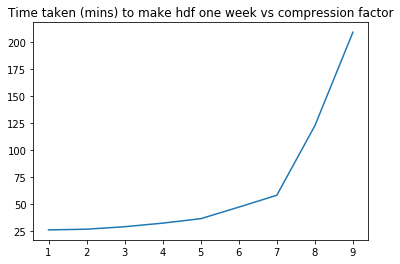

In [70]:
plt.plot(range(1,10), time_compression)
plt.title('Time taken (mins) to make hdf one week vs compression factor')

Text(0.5, 1.0, 'Size of output file (MBs) one week vs compression factor')

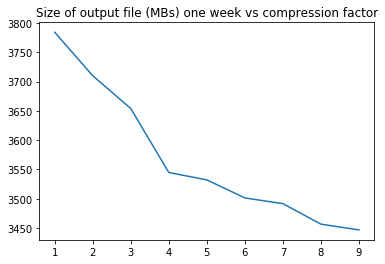

In [71]:
plt.plot(range(1,10), size_mb)
plt.title('Size of output file (MBs) one week vs compression factor')

In [110]:
test = open_file('foocurrents.hdf5')
getattr(h5current.root.Time, 'Time_00001').attrs

/Time/Time_00001._v_attrs (AttributeSet), 3 attributes:
   [Maximum := array([2016.]),
    Minimum := array([-0.]),
    Units := b'YYYY/MM/DD HH:MM:SS']

In [88]:
_v_attrs = h5py.AttributeManager(create('FillValue', np.array([0.]), shape=None, dtype=None))

NameError: name 'create' is not defined

In [95]:
f.close()

In [99]:
for i in test.walk_groups():
    print(i)

/ (RootGroup) ''
/Results (Group) ''
/Time (Group) ''
/Results/velocity U (Group) ''
/Results/velocity V (Group) ''
/Results/water level (Group) ''
